<a href="https://colab.research.google.com/github/AritraStark/Deeplense_GSOC_2022/blob/main/Deeplense_test_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Specific Test III. Learning Mass of Dark Matter Halo**

**Task:** Using the provided dataset implement a regression algorithm to learn the mapping between lensing images and the lensing dark matter halo mass. You can use the machine learning algorithm of your choice.  Please implement your approach in PyTorch or Keras and discuss your strategy.	

**Dataset:** [lens_data_alt.tgz](https://drive.google.com/file/d/1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j/view)

**Dataset Description:** The data set consists of strong lensing images for cold dark matter with subhalo substructure. For each lensing image the corresponding fraction of mass in dark matter substructure is provided.

**Evaluation Metrics:** MSE (mean squared error)


Downloading the data and extracting: 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!tar --extract --file '/content/gdrive/MyDrive/lens_data_alt.tgz' 
print('Extraction done.')

Mounted at /content/gdrive
Extraction done.


Setting up imports

In [5]:
import os
import numpy as np
import tensorflow as tf
import cv2
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
DATASET_PATH = './lens_data'
images = []
# f_sub -> mass fraction
f_subs = []
for f_name in os.listdir(DATASET_PATH):
  img, mass = np.load(os.path.join(DATASET_PATH,f_name),allow_pickle=True)
  # Add img and mass to separate lists
  # Add 1 as the first dimension for image
  images.append(img.reshape(1,img.shape[0],img.shape[1]))
  # Convert mass to a single element array with (1,1) dimensions
  f_subs.append(np.array(mass,ndmin=1))

# Images shape is (num_of_images,1,150,150)
images = np.stack(images).astype('float32')
# Mass fractions shape is (num_of_images,1)
f_subs = np.stack(f_subs).astype('float32')

In [ ]:
grid_size = (5,5)
figure,axis = plt.subplots(grid_size[0],grid_size[1],figsize=(15,15),sharey=True)
img_indx=0

for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    # Plotting image
    img = axis[i][j].imshow(images[img_indx][0], cmap='binary', origin='lower')
    # Setting up a title
    axis[i][j].set_title(f'f_sub: {f_subs[img_indx][0]:.2}')
    # Plotting a colorbar to show the intensity of pixels
    plt.colorbar(img,ax=axis[i][j],fraction=0.046, pad=0.04)

    img_indx+=1
plt.show()

In [3]:
dataset = os.listdir('lens_data')
X = []
y = []
j = 1
for i in dataset:
    data = np.load('lens_data/' + i, allow_pickle=True)
    img = data[0]
    img = img / 255.0
    img = cv2.resize(img, (64, 64))
    img = np.stack((img, img, img), axis=-1)
    X.append(img)
    y.append(data[1])
    print(j)
    j += 1

X = np.array(X)
y = np.array(y)
X.shape, y.shape

Streaming output truncated to the last 5000 lines.
15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062
15063
15064
15065
15066
15067
15068
15069
15070
15071
15072
15073
15074
15075
15076
15077
15078
15079
15080
15081
15082
15083
15084
15085
15086
15087
15088
15089
15090
15091
15092
15093
15094
15095
15096
15097
15098
15099
15100
15101
15102
15103
15104
15105
15106
15107
15108
15109
15110
15111
15112
15113
15114
15115
15116
15117
15118
15119
15120
15121
15122
15123
15124
15125
15126
15127
15128
15129
15130
15131
15132
15133
15134
15135
15136
15137
15138
15139
15140
15141
15142
15143
15144
15145
15146
15147
15148
15149
15150
15151
15152
15153
15154
15155
15156
15157
15158
1

((20000, 64, 64, 3), (20000,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

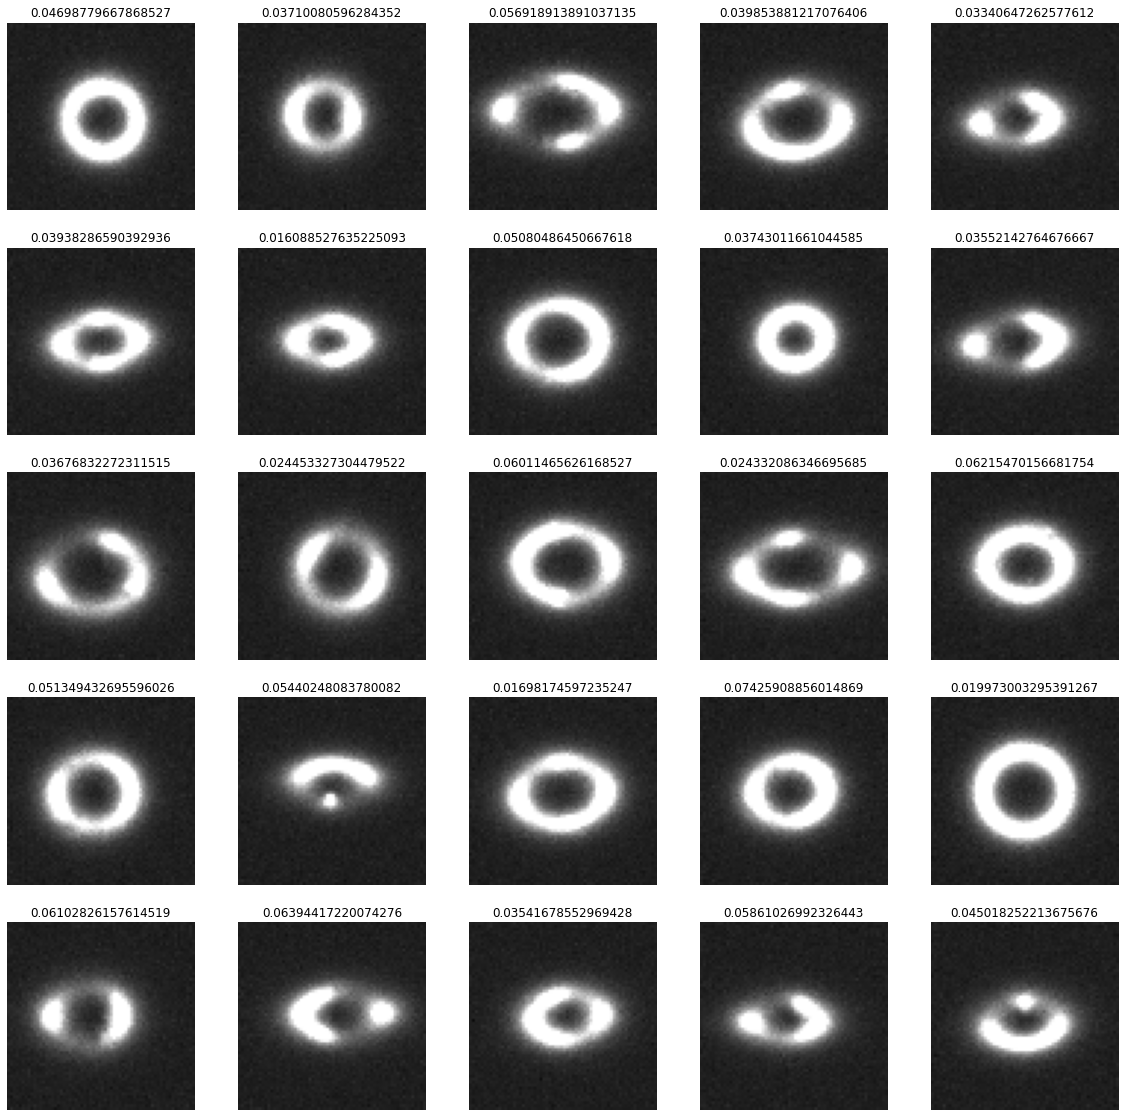

In [4]:
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.axis('off')
plt.show()

In [6]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

In [8]:
history = model.fit(train_X, train_y, epochs=10, validation_data=(test_X, test_y))

Epoch 1/10
563/563 [==============================] - 172s 303ms/step - loss: 5.4787e-04 - val_loss: 2.2038e-04
Epoch 2/10
563/563 [==============================] - 165s 294ms/step - loss: 2.1805e-04 - val_loss: 2.2087e-04
Epoch 3/10
563/563 [==============================] - 164s 291ms/step - loss: 2.1657e-04 - val_loss: 2.1759e-04
Epoch 4/10
563/563 [==============================] - 173s 308ms/step - loss: 2.1703e-04 - val_loss: 2.2640e-04
Epoch 5/10
563/563 [==============================] - 164s 291ms/step - loss: 2.1705e-04 - val_loss: 2.1461e-04
Epoch 6/10
563/563 [==============================] - 164s 292ms/step - loss: 2.1818e-04 - val_loss: 2.2004e-04
Epoch 7/10
563/563 [==============================] - 163s 290ms/step - loss: 2.1864e-04 - val_loss: 2.1922e-04
Epoch 8/10
563/563 [==============================] - 164s 290ms/step - loss: 2.1810e-04 - val_loss: 2.1588e-04
Epoch 9/10
563/563 [==============================] - 163s 290ms/step - loss: 2.1592e-04 - val_loss: 2.1

In [9]:
mse = model.evaluate(test_X, test_y)

63/63 [==============================] - 5s 75ms/step - loss: 2.1870e-04


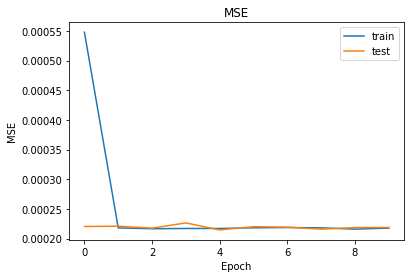

In [10]:
plt.figure()
plt.title('MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [11]:
model.save_weights('test-3-model-CNN.h5')